# Дослідження роботи алгоритмів Флойда-Воршала та Белмана-Формана, їхнє порівняння та аналіз

Завдання 1.2

Виконували: Лушпак Вікторія, Попенюк Софія

Постановка задачі: даний експеримент проводився з метою визначення ефективності використання двох алгоритмів - Флойда-Воршала та Белмана-Форда, а також задля порівняння даних алгоритмів з вбудованими інтерпретаціями. Сюди входило порівняння:
- швидкості виконання однієї задачі двома алгоритмами;
- їхніх можливостей (за умови від'ємних ваг чи від'ємних циклів);
- зручність та ефективність використання задля отримання результату;
- загальні характеристики;
- результат.


In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
from networkx.algorithms import floyd_warshall_predecessor_and_distance
from networkx.algorithms import bellman_ford_predecessor_and_distance
import time
from tqdm import tqdm


In [2]:
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
    return G

# Алгоритм Флойда-Воршала

In [10]:
def floyd_warshall(edges: 'Graph') -> list:
    """
    Returns the matrix of weights based on the
    original one.
    """
    edges_dict = dict(edges.adjacency())
    vertices = len(edges_dict)
    table = [['inf' for _ in range(vertices)] for _ in range(vertices)]
    for ver in range(vertices):
        table[ver][ver] = 0
    for edge, weights in edges_dict.items():
        for v, w in weights.items():
            for _, wei in w.items():
                table[edge][v] = wei
    for k in range(vertices):
        for i in range(vertices):
            for j in range(vertices):
                try:
                    if table[i][j] > table[i][k] + table[k][j]:
                        table[i][j] = table[i][k] + table[k][j]
                except TypeError:
                    if table[i][j] == 'inf' and not isinstance(table[i][k], str) and not isinstance(table[k][j], str):
                        table[i][j] = table[i][k] + table[k][j]
    #Check for negative cycles
    for i in range(vertices):
        if table[i][i] < 0:
            return "Negative cycle detected"
    return table

G1 = gnp_random_connected_graph(5, 1)
print(floyd_warshall(G1))

G2 = gnp_random_connected_graph(5, 0.5)
print(floyd_warshall(G2))

[[0, 12, 16, 20, 11], [12, 0, 18, 11, 12], [16, 18, 0, 15, 18], [20, 11, 15, 0, 11], [11, 12, 18, 11, 0]]
Negative cycle detected


Функція floyd_warshall() приймає початкову матрицю з основними вагами, яка подається у вигляді словника, де ключ - це основна вершина, а значення - це словники, де ключ - вершина, а значення - вага шляху до основної вершини. Якщо такого шляху немає - замість безмежності записуємо 'inf'. В результаті повертається матриця кінцевої ітерації за алгоритмом Флойда-Воршала. Варто зазначити, що вершини повинні починатися з нульової (!).

Як для алгоритму Флойда-Воршала, так і для Белмана-Форда, у графі можливі від'ємні ваги, однак від'ємні цикли неприпустимі, адже тоді цикл обчислення алгоритму ніколи не закінчиться, або буде видавати неправильний результат. Якщо ж виявляється, що в алгоритмі є від'ємний цикл, виводиться відповідне повідомлення (бачимо у другому графі). Якщо ж все гаразд та від'ємних циклів немає, функція повертає матрицю ваг у вигляді списку списків.

Примітка: під час проведення експерименту виявилось, що вбудований алгоритм не завжди правильно визначає від'ємний цикл, тому результати порівняння можуть бути не точними.

100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s]


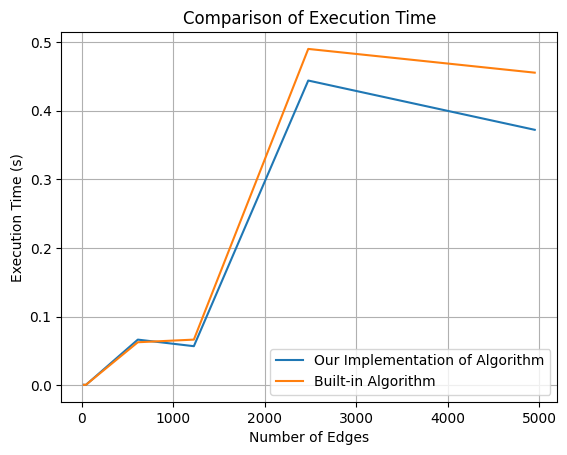

In [11]:
NUM_OF_ITERATIONS = 1000
graph_sizes = [10, 50, 100]
fullness_levels = [0.5, 1]

main_execution_times = []
built_in_algorithm_execution_times = []
num_edges = []

for size in graph_sizes:
    for fullness in fullness_levels:
        my_time = 0
        built_in_time = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            G = gnp_random_connected_graph(size, fullness, False, False)
            start_main_execution = time.time()
            try:
                main_execution_time = floyd_warshall(G)
            except Exception:
                pass
            end_main_execution = time.time()
            my_time += end_main_execution - start_main_execution
            
            start_built_in_execution = time.time()
            try:
                built_in_algorithm_execution_time = floyd_warshall_predecessor_and_distance(G)
            except Exception:
                pass
            end_built_in_execution = time.time()
            built_in_time += end_built_in_execution - start_built_in_execution
        
        main_execution_times.append(my_time / 1000)
        built_in_algorithm_execution_times.append(built_in_time / 1000)
        num_edges.append(size * (size - 1) / 2 * fullness)

plt.plot(num_edges, main_execution_times, label='Our Implementation of Algorithm')
plt.plot(num_edges, built_in_algorithm_execution_times, label='Built-in Algorithm')
plt.xlabel('Number of Edges')
plt.ylabel('Execution Time (s)')
plt.title('Comparison of Execution Time')
plt.legend()
plt.grid(True)
plt.show()

Як ми бачимо з графіку, приблизно до 2000 ребер обидві інтерпретації працюють майже ідентично по швидкості, однак починаючи з 2500 можна помітити різницю у 0.05-0.1 секунд. Наш алгоритм Флойда-Воршала працює швидше, проте варто відмітити, що за даної складності графа (а саме 0.5-1) у більшості випадків будуть знайдені від'ємні цикли (це ми визначили після тривалого тестування функцій). Можна зробити висновок, що для невеликої кількості ребер можна використовувати будь-який алгоритм, вбудований чи нашої інтерпретації, адже результат буде однаковим, незалежно від від'ємних ваг вершин чи циклів. Однак на більшій кількості ребер (та, відповідно, вершин), ефективніше буде використовувати алгоритм нашої розробки.

# Алгоритм Белмана-Форда

In [19]:
def bellman_ford(edges: 'Graph', start: int) -> list:
    """
    Returns the line of weights that show the
    shortest way to other vertices, starting
    from the start.
    """
    edges_dict = dict(edges.adjacency())
    table = [['inf' for _ in range(len(edges_dict))] for _ in range(len(edges_dict))]

    for edge, weights in edges_dict.items():
        for v, w in weights.items():
            for _, wei in w.items():
                table[edge][v] = wei

    iterations = len(edges) - 1
    needed = table[start]
    needed[start] = 0
    for _ in range(iterations):
        for k, v1 in enumerate(needed):
            for n, v2 in enumerate(table[k]):
                try:
                    needed[n] = min(needed[n], v1 + v2)
                except TypeError:
                    if needed[n] == 'inf' and not isinstance(v1, str) and not isinstance(v2, str):
                        needed[n] = v1 + v2
    #Check for negative cycles
    for k, v1 in enumerate(needed):
        for n, v2 in enumerate(table[k]):
            try:
                if needed[n] > v1+v2:
                    return "Negative cycle detected"
            except TypeError:
                pass
    return needed

G3 = gnp_random_connected_graph(5, 1)
print(bellman_ford(G3, 0))

G4 = gnp_random_connected_graph(5, 0.5)
print(bellman_ford(G4, 0))

[0, 9, 13, 4, 5]
Negative cycle detected


Як бачимо, алгоритм Белмана-Форда повертає лише одну лінійку з матриці, що відповідає початковій вершині, яку потрібно вказати при виклику функції (у даному прикладі ми використали вершину 0), та відстані до інших вершин від заданої початкової. Знову ж таки, цей алгоритм не може коректно працювати, якщо в графі є від'ємний цикл, тому алгоритм повідомляє про його знаходження та не вертає жодного результату (як показано у другому прикладі). З від'ємними вагами Белман-Форд справляється без жодних труднощів, як і Флойд-Воршал.

100%|██████████| 1000/1000 [09:59<00:00,  1.67it/s]


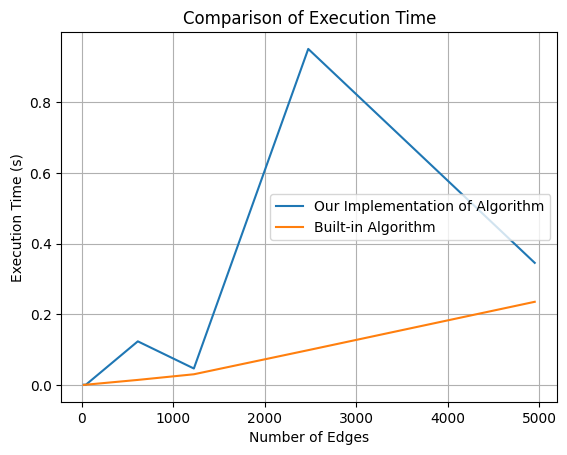

In [20]:
NUM_OF_ITERATIONS = 1000
graph_sizes = [10, 50, 100]
fullness_levels = [0.5, 1]

main_execution_times = []
built_in_algorithm_execution_times = []
num_edges = []

for size in graph_sizes:
    for fullness in fullness_levels:
        my_time = 0
        built_in_time = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            G = gnp_random_connected_graph(size, fullness, False, False)
            start_main_execution = time.time()
            try:
                main_execution_time = bellman_ford(G, 0)
            except Exception:
                pass
            end_main_execution = time.time()
            my_time += end_main_execution - start_main_execution
            
            start_built_in_execution = time.time()
            try:
                built_in_algorithm_execution_time = bellman_ford_predecessor_and_distance(G, 0)
            except Exception:
                pass
            end_built_in_execution = time.time()
            built_in_time += end_built_in_execution - start_built_in_execution
        
        main_execution_times.append(my_time / 1000)
        built_in_algorithm_execution_times.append(built_in_time / 1000)
        num_edges.append(size * (size - 1) / 2 * fullness)

plt.plot(num_edges, main_execution_times, label='Our Implementation of Algorithm')
plt.plot(num_edges, built_in_algorithm_execution_times, label='Built-in Algorithm')
plt.xlabel('Number of Edges')
plt.ylabel('Execution Time (s)')
plt.title('Comparison of Execution Time')
plt.legend()
plt.grid(True)
plt.show()


Можна одразу відмітити, що на великій кількості ребер наш алгоритм Белмана-Форда почав виснути та йому знадобилось досить багато часу, аби зробити всі ітерації. Це може бути пов'язано з процесом перевірки на від'ємний цикл, тоді як у вбудованому алгоритмі він, на нашу думку, працює ефективніше та "плавніше", адже максимальний час роботи при 5000 ребер не досягає й позначки у 0.3 секунди. Також така різниця в часі може бути обумовлена кількістю ітерацій: незважаючи на те, що за алгоритмом вона дорівнює V-1, де V - кількість вершин, в деяких випадках кількість ітерацій можна скоротити. Це відбувається тоді, коли наступна ітерація не відрізняється від попередньої, тоді можна упустити наступні ітерації та задавати результат одразу без них. Наш алгоритм працює чітко на усіх V-1 ітераціях. Тому якщо говорити про ефективність, ми б надали перевагу вбудованому алгоритму Белмана-Форда.

# Підсумки

Отже, провівши даний експеримент, ми можемо зробити такі висновки:
- вибрати один алгоритм однієї інтерпретації досить складно, адже на різній кількості ребер та вершин алгоритми справляються по різному
- що алгоритм Белмана-Форда, що Флойда-Воршала працюють при від'ємних вагах вершин, чого не скажеш про, наприклад, алгоритм Деікстри. Однак на від'ємному циклі алгоритми не можуть працювати, адже або результат буде не точний, або з'явиться нескінченний цикл
- якщо ж говорити про результати, то наш алгоритм Флойда-Воршала майже не відрізняється від вбудованого, результати надходять досить швидко, а також виявлення від'ємних циклів працює без винятків. Після 2500 ребер, як показав наш експеримент, швидкість алгоритму навіть зростає та, відповідно, наш алгоритм виконується ефективніше, ніж вбудований
- алгоритм Белмана-Форда, натомість, має неоднозначні результати. Скоріш за все, це пов'язано з кількістю ітерацій. Оскільки ми тестували наші алгоритми на 10-100 вершинах, то, відповідно, й ітерацій була досить велика кількість, а для виявлення від'ємних циклів проводились ще додаткові ітерації. Тому в даному випадку більшу ефективність має вбудований алгоритм, який працює "плавно", незважаючи на від'ємні цикли та ваги.